##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Predict house prices: regression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/samples/core/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/samples/core/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to predict a discrete label (for example, where a picture contains an apple or an orange). 

This notebook builds a model to predict the median price of homes in a Boston suburb during the mid-1970s. To do this, we'll provide the model with some data points about the suburb, such as the crime rate and the local property tax rate.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.4.1


## The Boston Housing Prices dataset

This [dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) is accessible directly in TensorFlow. Download and shuffle the training set:

In [ ]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

### Examples and features 

This dataset is much smaller than the others we've worked with so far: it has 506 total examples are split between 404 training examples and 102 test examples:

In [ ]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


The dataset contains 13 different features:

1.   Per capita crime rate.
2.   The proportion of residential land zoned for lots over 25,000 square feet.
3.   The proportion of non-retail business acres per town.
4.   Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5.   Nitric oxides concentration (parts per 10 million).
6.   The average number of rooms per dwelling.
7.   The proportion of owner-occupied units built before 1940.
8.   Weighted distances to five Boston employment centers.
9.   Index of accessibility to radial highways.
10.  Full-value property-tax rate per $10,000.
11.  Pupil-teacher ratio by town.
12.  1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13.  Percentage lower status of the population.

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

Key Point: As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias? For more information, read about [ML fairness](https://developers.google.com/machine-learning/fairness-overview/).

In [ ]:
print(train_data[0])  # Display sample features, notice the different scales

[ 24.3938   0.      18.1      0.       0.7      4.652  100.       1.4672
  24.     666.      20.2    396.9     28.28  ]


Use the [pandas](https://pandas.pydata.org) library to display the first few rows of the dataset in a nicely formatted table:

In [ ]:
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.39380,0.0,18.10,0.0,0.700,4.652,100.0,1.4672,24.0,666.0,20.2,396.90,28.28
1,6.71772,0.0,18.10,0.0,0.713,6.749,92.6,2.3236,24.0,666.0,20.2,0.32,17.44
2,0.00906,90.0,2.97,0.0,0.400,7.088,20.8,7.3073,1.0,285.0,15.3,394.72,7.85
3,0.03113,0.0,4.39,0.0,0.442,6.014,48.5,8.0136,3.0,352.0,18.8,385.64,10.53
4,0.01096,55.0,2.25,0.0,0.389,6.453,31.9,7.3073,1.0,300.0,15.3,394.72,8.23


### Labels

The labels are the house prices in thousands of dollars. (You may notice the mid-1970s prices.)

In [ ]:
print(train_labels[0:10])  # Display first 10 entries

[10.5 13.4 32.2 17.5 22.  17.2 22.9 30.3 23.9 50. ]


## Normalize features

It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation:

In [ ]:
# Test data is *not* used when calculating the mean and std.

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[ 2.23729971 -0.48361547  1.0283258  -0.25683275  1.21764133 -2.27826496
  1.11048828 -1.12100914  1.67588577  1.5652875   0.78447637  0.44807713
  2.14464877]


Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependant on the choice of units used in the input.

## Create the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [ ]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, 
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  # optimizer = tf.train.RMSPropOptimizer(0.001)
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Train the model

The model is trained for 500 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Visualize the model's training progress using the stats stored in the `history` object. We want to use this data to determine how long to train *before* the model stops making progress.

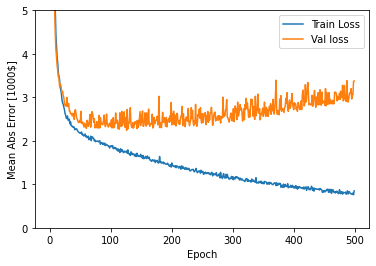

In [ ]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label ='Val loss')
  plt.legend()
  plt.ylim([0,5])

plot_history(history)

This graph shows little improvement in the model after about 200 epochs. Let's update the `model.fit` method to automatically stop training when the validation score doesn't improve. We'll use a *callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


....................................................................................................
....

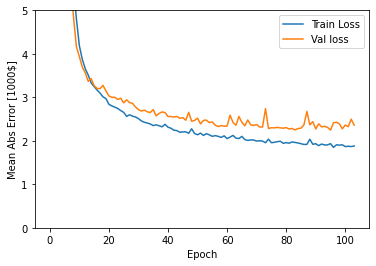

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows the average error is about \\$2,500 dollars. Is this good? Well, \$2,500 is not an insignificant amount when some of the labels are only $15,000.

Let's see how did the model performs on the test set:

In [ ]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2851.51


## Predict

Finally, predict some housing prices using data in the testing set:

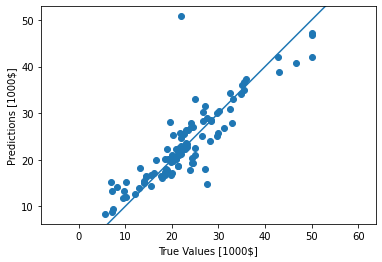

In [ ]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100],[-100,100])


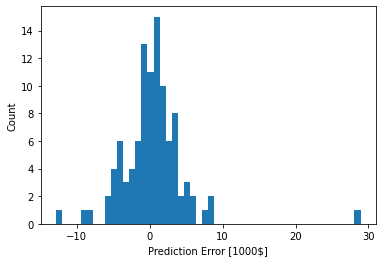

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When input data features have values with different ranges, each feature should be scaled independently.
* If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.